In [1]:
eqLabelWithNumbers=0
%run nbinit.ipy
js_addon()

... Configuring matplotlib formats
... Configuring matplotlib with inline figures
... Importing numpy as np, scipy as sp, pyplot as plt, scipy.stats as stats
   ... scipy.signal as sig
... Importing widgets, display, HTML, Image, Javascript
... Loading customized Javascript for LaTeX typesetting
... Some LaTeX definitions


... Defining figures captions 


... Loading customized Javascript for interactive solutions (show/hide)
Overriding run-range javascript function


In [2]:
cp /home/bercherj/Téléchargements/fecg.mat .


In [96]:
import scipy.io
xx=scipy.io.loadmat("fecg.mat")
print(xx.keys())
abdomen1=xx['abdomen1']
abdomen2=xx['abdomen2']
abdomen3=xx['abdomen3']
thorax1=xx['thorax1']
thorax2=xx['thorax2']

dict_keys(['__header__', 'thorax2', 'abdomen1', '__version__', 'thorax1', 'abdomen3', '__globals__', 'abdomen2'])


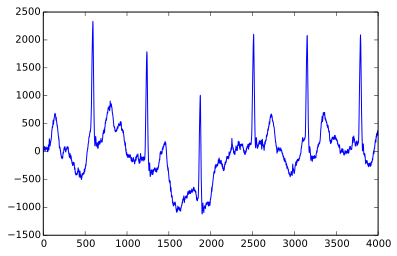

In [98]:
plt.plot(abdomen1[0:4000])

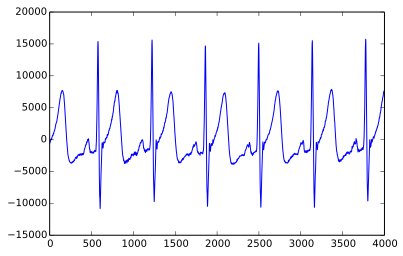

In [224]:
plt.plot(thorax1[1:4000]+thorax2[1:4000])

In [13]:
def lms(d,u,w,mu):
    """ 
    Implements a single iteration of the stochastic gradient (LMS)\n
    :math:`w(n+1)=w(n)+\\mu u(n)\\left(d(n)-w(n)^T u(n)\\right)̀`
    

    Input:
    ======
        d : wanted sequence at time n \n
        u : vecteur de longueur p des échantillons d'entrée \n
        w : wiener filter to update \n
        mu : adaptation step
    
    Outputs:
    =======
        w : upated filter
        err : y-yest
        dest : prediction = :math:`u(n)^T w` 
    """
    u=squeeze(u) #Remove single-dimensional entries from the shape of an array.
    w=squeeze(w)
    #print(size(u))
    #print(size(w))
    dest=u.dot(w)
    err=d-dest
    w=w+mu*u*err
    """print(w)
    print("a priori error:", err)
    print("a posterori error:", d-u.dot(w))"""
    
    return (w,err,dest)

In [14]:
def noisecancel_2(ref,signal,h_ini,mu,normalized=False):
    """
    Noise cancellation algorithm
    Inputs:
    =======
    ref: array
        noise reference
	signal:  array
        signal path (signal mixture s +b, where b is correlated with ref
    h_ini: array
        initial impulse response
    mu: adaptation step
    Outputs:
    ========
    h: array
        identified impulse response 
    s: array
        signal identified by noise cancellation
	b_est: array
        noise on the signal path estimated from ref
    """


    ref=squeeze(ref) 
    signal=squeeze(signal) 
    h_ini=squeeze(h_ini)

    N=size(signal)
    L=(size(h_ini)+1)//2
    h=h_ini
    s=zeros(N)
    b_est=zeros(N)
    
    for t in range(L,N-L+1):
         """print("t",t)
         print("mu",mu)    """
         u=np.array(1.0*(ref[t+L-1:t-L:-1]))
         """print('u',u)
         print(type(u))
         print("uu",u.dot(u))   """
         
         if normalized:
            mun=mu/(u.dot(u)+1e-30)   
         else:
            mun=mu
         #print("mun",mun)   
         (h, s[t],b_est[t]) = lms(signal[t], u, h, mun)
            
         #print(s[t])

    return (h,s,b_est)

In [140]:
def noisecancel(ref,signal,h_ini,mu,normalized=False):
    """
    Noise cancellation algorithm
    Inputs:
    =======
    ref: array
        noise reference
	signal:  array
        signal path (signal mixture s +b, where b is correlated with ref
    h_ini: array
        initial impulse response
    mu: adaptation step
    Outputs:
    ========
    h: array
        identified impulse response 
    s: array
        signal identified by noise cancellation
	b_est: array
        noise on the signal path estimated from ref
    """


    ref=squeeze(ref) 
    signal=squeeze(signal) 
    h_ini=squeeze(h_ini)

    N=size(signal)
    L=size(h_ini)
    h=h_ini
    s=zeros(N)
    b_est=zeros(N)
    
    for t in range(L,N):
         u=ref[t:t-L:-1]
         if normalized:
            mun=mu/(dot(u,u)+1e-10)   
         else:
            mun=mu
         (h, s[t],b_est[t]) = lms(signal[t], u, h, mun)

    return (h,s,b_est)


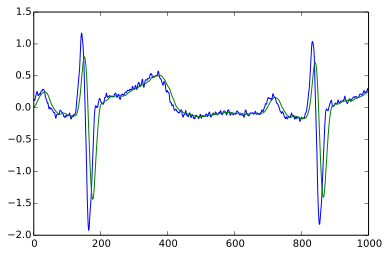

In [259]:
tho=sig.lfilter(1/20*ones(20),[1],thorax1)
plt.plot(thorax1[0:1000])
plt.plot(tho[0:1000])

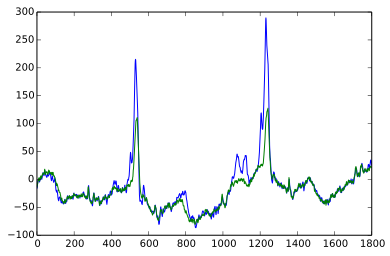

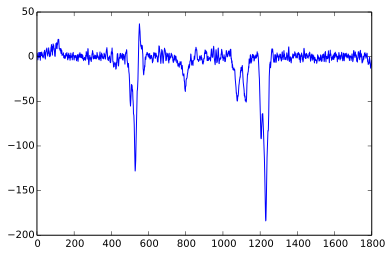

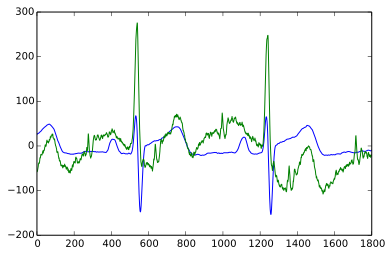

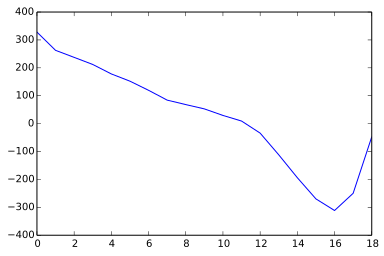

In [292]:
#abdo=sig.lfilter(1/500*ones(500),[1],abdomen1)
#abdo=abdomen1-abdo
tho=sig.lfilter(1/20*ones(20),[1],thorax1)
#tho=abdomen1-abdo
a=10000
b=a+20000
d=-10
(h,s,b_est) = noisecancel_2(tho[a-d:b-d],abdomen2[a:b],zeros(19),0.691,normalized=True)

plt.plot(b_est[10000:11800])
plt.plot(abdomen2[a+10000:a+11800])


plt.figure()
plt.plot(s[10000:11800])
plt.figure()
plt.plot(100*tho[a+10000:a+11800])
plt.plot(abdomen1[a+10000:a+11800])
#plt.plot(s[10000:15800]+0*b_est[10000:15800])
figure()
plot(h)

In [80]:
# Implementation using the array type
def algo_rls(u,d,M,plambda):
    N=size(u)
# initialization
    e=zeros(N)
    wrls=zeros((M,N+1))
    Krls=100*eye(M)
    u_v=zeros(M)
    for n in range(N):
        u_v[0]=u[n]
        u_v[1:M]=u_v[0:M-1]#concatenate((u[n], u_v[1:M]), axis=0)
        e[n]=conj(d[n])-dot(conj(u_v),wrls[:,n])
        #print("n={}, Erreur de {}".format(n,e[n]))
        Kn=Krls/plambda
        Krls=Kn-dot(Kn,dot(outer(u_v,conj(u_v)),Kn))/(1+dot(conj(u_v),dot(Kn,u_v)))
        wrls[:,n+1]=wrls[:,n]+dot(Krls,u_v)*conj(e[n])
    return (wrls,e)

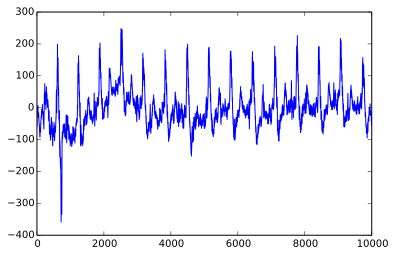

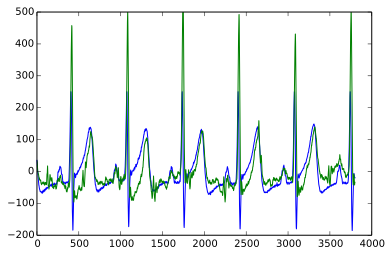

In [86]:
(wrls,err)=algo_rls(thorax1[0:10000],abdomen1[0:10000],150,0.999)

plt.plot(err[0:10000])
plt.plot(abdomen1[0:10000])


#plt.figure()
#plt.plot(s[10000:13800])
plt.figure()
plt.plot(100*thorax1[10000:13800])
plt.plot(abdomen1[10000:13800])
#plt.plot(s[10000:15800]+0*b_est[10000:15800])


In [293]:
cp /home/bercherj/Téléchargements/FOETAL_ECG.dat .

In [299]:
A=np.loadtxt("FOETAL_ECG.dat",skiprows=0)
time=A[:,0]
abdomen1=A[:,1]
abdomen2=A[:,2]
abdomen3=A[:,3]
abdomen4=A[:,4]
abdomen5=A[:,5]
thorax1=A[:,6]
thorax2=A[:,7]
thorax3=A[:,8]

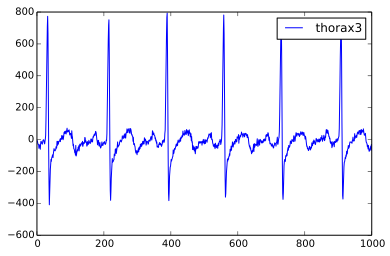

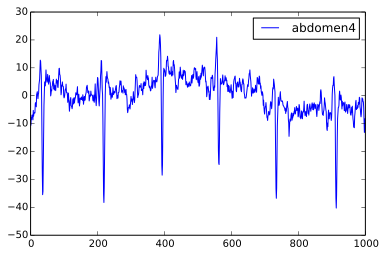

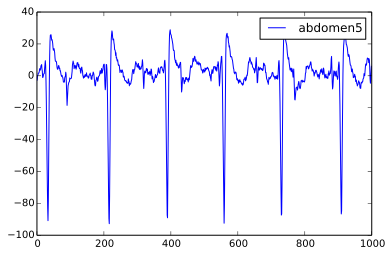

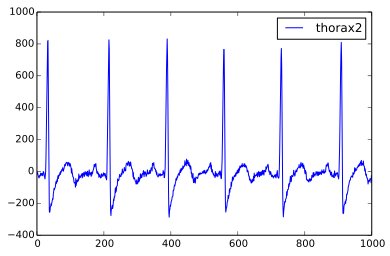

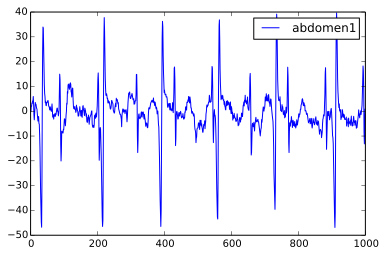

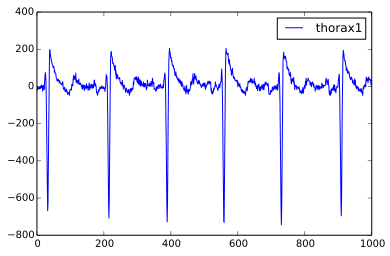

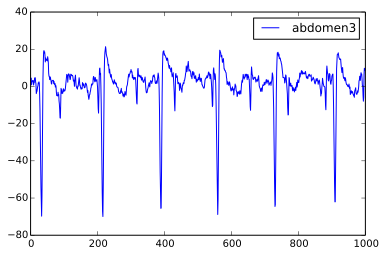

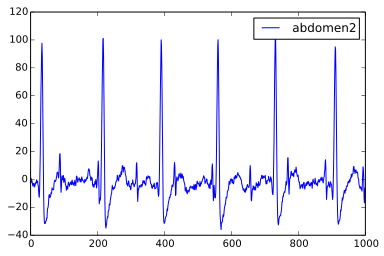

In [302]:
liste={"abdomen1":abdomen1, "abdomen2":abdomen2, "abdomen3":abdomen3, "abdomen4":abdomen4, 
       "abdomen5":abdomen5, "thorax1":thorax1, "thorax2":thorax2, "thorax3":thorax3}
for k in liste.keys():
    plt.plot(liste[k][0:1000],label=k)
    plt.legend()
    plt.figure()

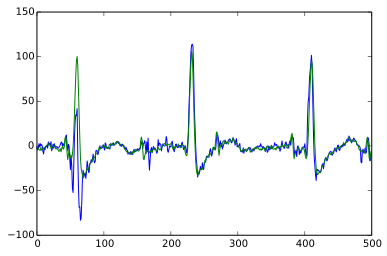

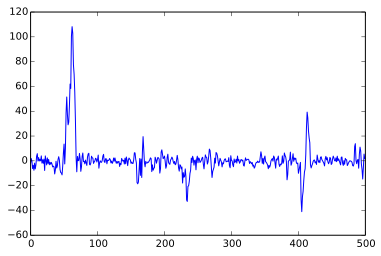

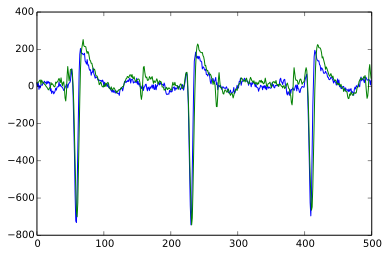

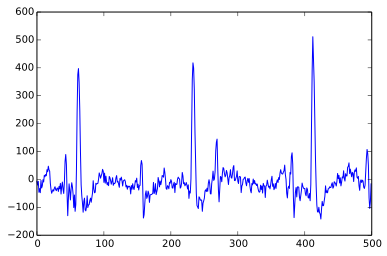

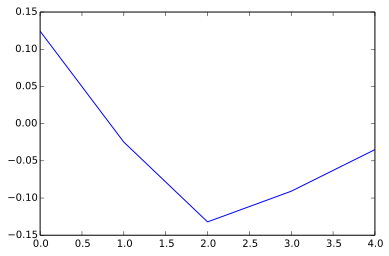

In [327]:
#abdo=sig.lfilter(1/500*ones(500),[1],abdomen1)
#abdo=abdomen1-abdo
#tho=sig.lfilter(1/20*ones(20),[1],thorax1)
#tho=abdomen1-abdo
a=10000
b=a+20000
d=-10
tho=thorax1
abdo=abdomen2
(h,s,b_est) = noisecancel(tho,abdo,zeros(5),0.91,normalized=True)

plt.plot(b_est[500:1000])
plt.plot(abdo[500:1000])


plt.figure()
plt.plot(s[500:1000])
plt.figure()
plt.plot(tho[500:1000])
plt.plot(-7*abdo[500:1000])
figure()
plt.plot(tho[500:1000]+8*abdo[500:1000])
#plt.plot(s[10000:15800]+0*b_est[10000:15800])
figure()
plot(h)

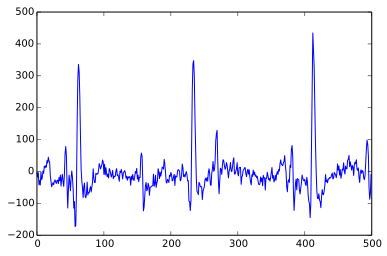

In [325]:
plt.plot(tho[500:1000]+7*abdo[500:1000])

In [111]:
A=np.loadtxt("ecgca840_data.txt",skiprows=1, delimiter=",")
time=A[:,0]
thorax1=A[:,1]
thorax2=A[:,2]
abdomen1=A[:,3]
abdomen2=A[:,4]
abdomen3=A[:,5]
abdomen4=A[:,6]


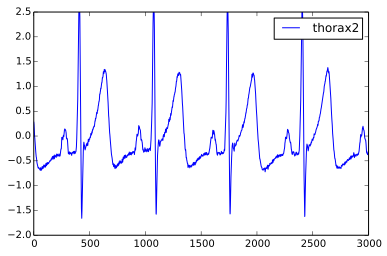

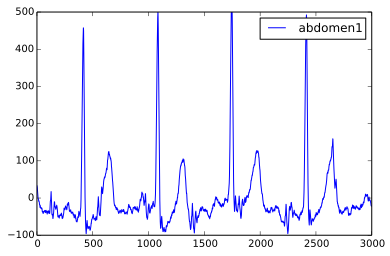

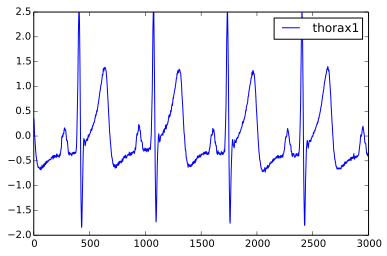

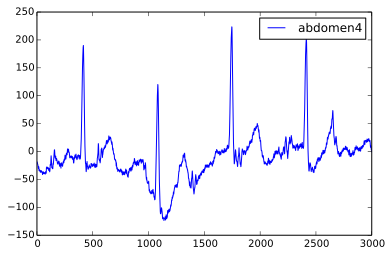

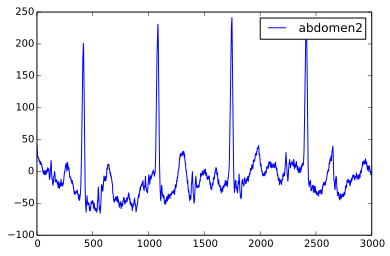

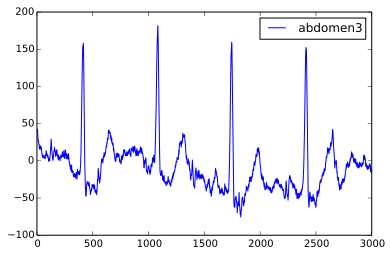

In [41]:
liste={"abdomen1":abdomen1, "abdomen2":abdomen2, "abdomen3":abdomen3, "abdomen4":abdomen4, 
       "thorax1":thorax1, "thorax2":thorax2}
for k in liste.keys():
    plt.plot(liste[k][10000:13000],label=k)
    plt.legend()
    plt.figure()

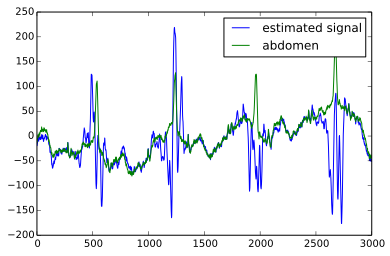

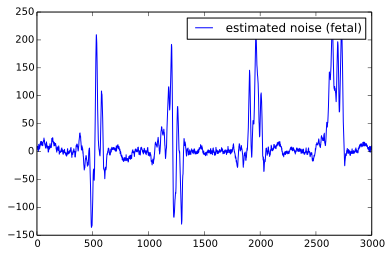

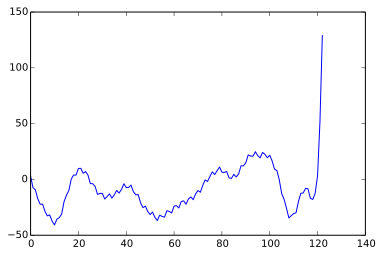

In [190]:
abdo=abdomen2
def ppp(delay,order):
    (h,s,b_est) = noisecancel_2(thorax2[10000+delay:40000+delay],abdo[10000:40000],
                                zeros(order),0.9,normalized=True)
    plt.plot(b_est[10000:13000],label="estimated signal")
    plt.plot(abdo[20000:23000],label='abdomen')
    plt.legend()
    figure()
    plt.plot(s[10000:13000],label="estimated noise (fetal)")
    plt.legend()
    """plt.figure()
    plt.plot(s[10000:13000])
    plt.figure()
    plt.plot(150*thorax2[10000:13000])
    plt.plot(abdomen1[10000:13000])
    #plt.plot(s[10000:15800]+0*b_est[10000:15800])
    """

    figure()
    plot(h)
interact(ppp,delay=widgets.IntSliderWidget(min=-1500,max=1500),order=widgets.IntSliderWidget(min=1,max=500, step=2, value=1))     

In [375]:
3//2

1

In [ ]:
####### Old Lab ########

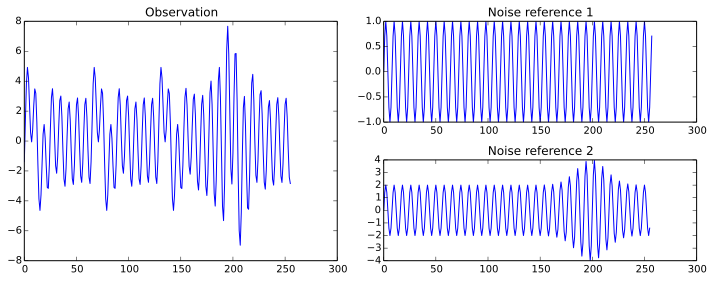

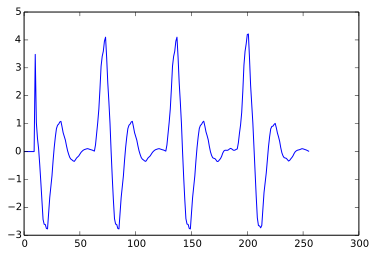

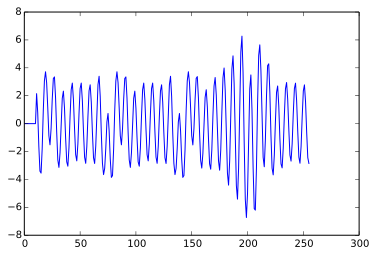

In [129]:
import numpy
f=numpy.load('sb1.npz')
# f is a dictionary
# its keys are given by
f.keys()
# Then the contents are affected to local variables
obs=f['obs']
ref1=f['ref1']
ref2=f['ref2']
import matplotlib.gridspec as gridspec
G = gridspec.GridSpec(2, 2)

fig=figure(figsize=(10,4))
ax1 = subplot(G[0:, 0])
ax1.plot(obs)
title("Observation")
ax2 = subplot(G[0, 1])
ax2.plot(ref1)
title("Noise reference 1")

ax3 = subplot(G[1, 1])
ax3.plot(ref2)
title("Noise reference 2")
fig.tight_layout()   #avoid covering of titles and labels
plt.figure()
# With the non stationary reference
(h,s,sest)=noisecancel(ref2,obs,zeros(10),0.8,normalized=True)
plot(s)
figure()
plot(sest)

In [128]:
cp ../sb1.npz .